# Track filtering/fitting with LSTMs

This is a continuous space model using the ACTS data.

In this notebook we load a pre-trained model and simply make some evaluation plots.

In [1]:
from __future__ import print_function

# System imports
import os

# Data libraries
import numpy as np
import pandas as pd

# Torch imports
import torch

# Visualization
import matplotlib.pyplot as plt

# Local imports
import torchutils
torchutils.set_cuda(False)
from torchutils import np_to_torch, torch_to_np
from track_filter import coord_scale

# Magic
%matplotlib notebook

## Read the data

In [2]:
data_dir = '/global/cscratch1/sd/sfarrell/heptrkx/filter_data_004/'
model_file = '/global/cscratch1/sd/sfarrell/heptrkx/RNNFilter-Dec11/model'
losses_file = '/global/cscratch1/sd/sfarrell/heptrkx/RNNFilter-Dec11/losses.npz'

In [3]:
#train_data = np.load(os.path.join(data_dir, 'train_data.npy'))
test_data = np.load(os.path.join(data_dir, 'test_data.npy'))

losses_data = np.load(losses_file)
train_losses = losses_data['train_losses']
valid_losses = losses_data['valid_losses']

# Load the pre-trained model
model = torch.load(model_file)
model.eval()
model

HitPredictor (
  (lstm): LSTM(3, 20, batch_first=True)
  (fc): Linear (20 -> 2)
)

In [4]:
# Inputs are the hits from [0, N-1)
# Targets are the hits from [1, N) without the 'r' feature.
#train_input = np_to_torch(train_data[:,:-1])
#train_target = np_to_torch(train_data[:,1:,:2])
test_input = np_to_torch(test_data[:,:-1])
test_target = np_to_torch(test_data[:,1:,:2])

## Training loss

<IPython.core.display.Javascript object>


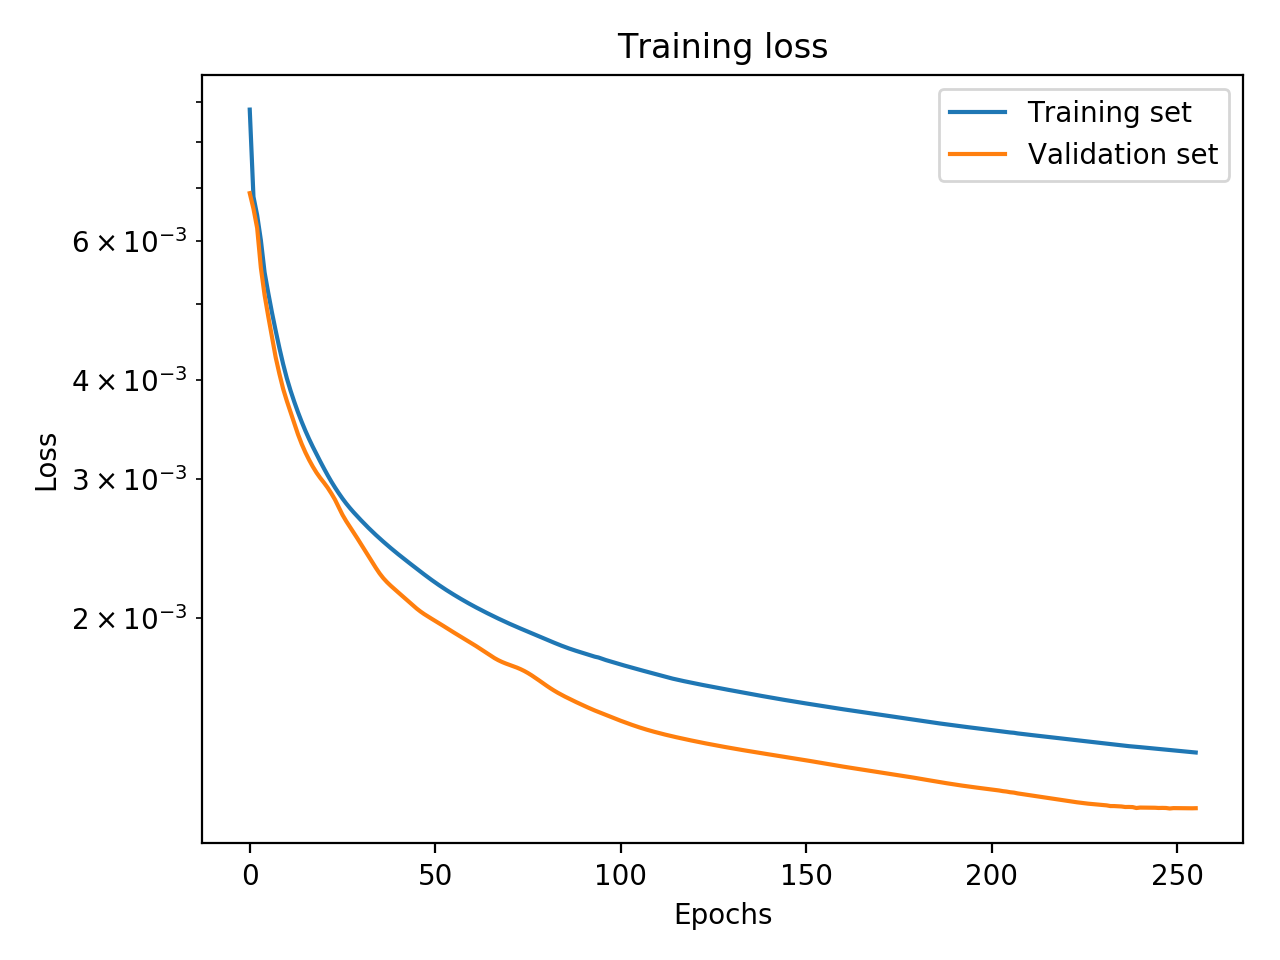

In [5]:
plt.figure()
plt.semilogy(train_losses, label='Training set')
plt.semilogy(valid_losses, label='Validation set')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training loss')
plt.legend(loc=0)
plt.tight_layout()

## Evaluate model performance

In [9]:
# Get the predictions and errors for the full training set
#train_output = model(train_input)
#train_error = train_output - train_target
#train_resid = train_error.cpu().data.numpy() * coord_scale[:2]

# Get the predictions and errors for the full test set
test_output = model(test_input)
test_error = test_output - test_target
test_resid = test_error.cpu().data.numpy() * coord_scale[:2]

<IPython.core.display.Javascript object>


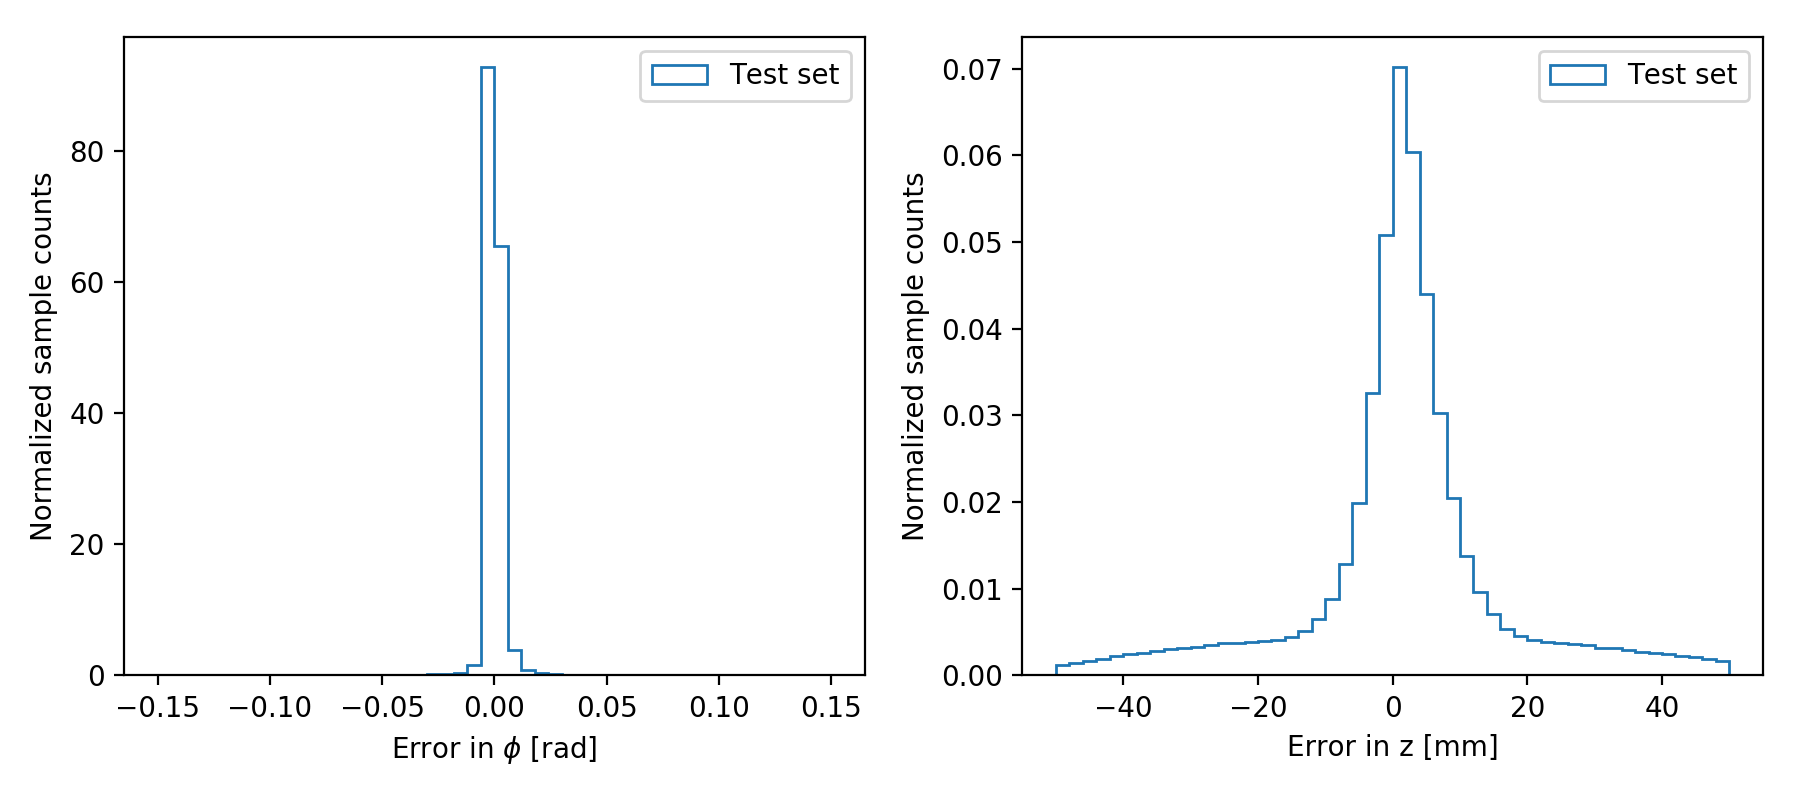

In [10]:
plt.figure(figsize=(9,4))
plt.subplot(121)
hist_args = dict(bins=50, range=(-0.15, 0.15), normed=True, log=False, histtype='step')
#plt.hist(train_resid[:,:,0].flatten(), label='Training set', **hist_args)
plt.hist(test_resid[:,:,0].flatten(), label='Test set', **hist_args)
plt.xlabel('Error in $\phi$ [rad]')
plt.ylabel('Normalized sample counts')
plt.legend(loc=0)

plt.subplot(122)
hist_args = dict(bins=50, range=(-50, 50), normed=True, log=False, histtype='step')
#plt.hist(train_resid[:,:,1].flatten(), label='Training set', **hist_args)
plt.hist(test_resid[:,:,1].flatten(), label='Test set', **hist_args)
plt.xlabel('Error in z [mm]')
plt.ylabel('Normalized sample counts')
plt.legend(loc=0)
plt.tight_layout()

## Visualize trajectories

<IPython.core.display.Javascript object>


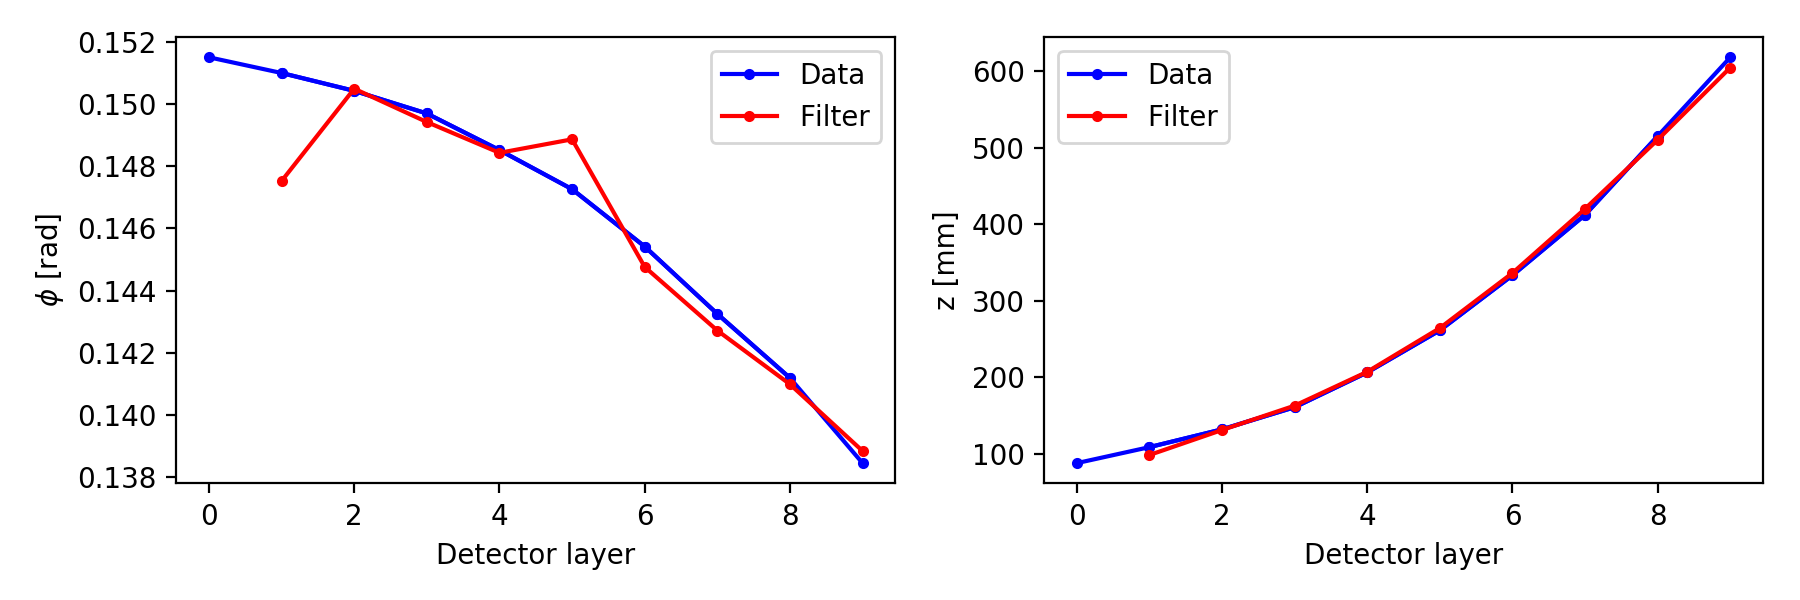

<IPython.core.display.Javascript object>


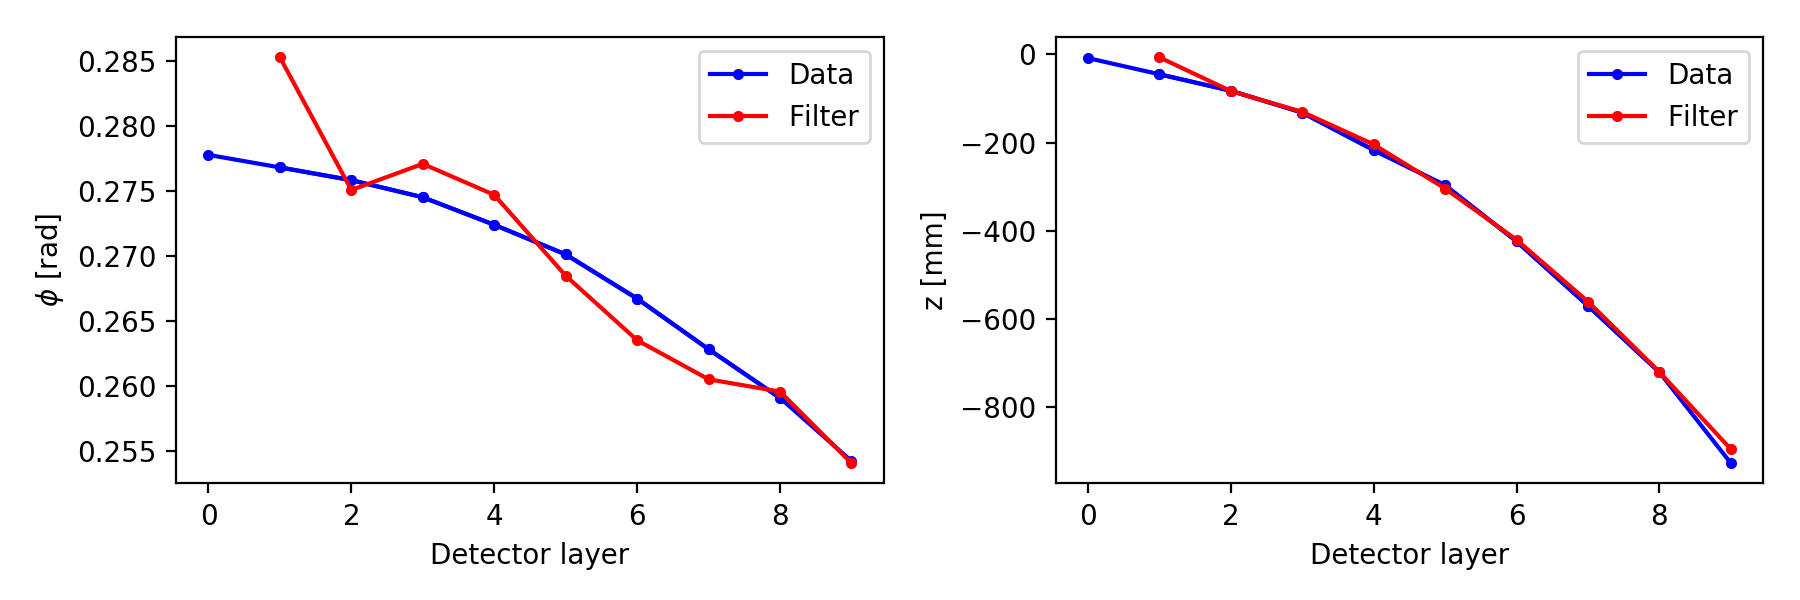

<IPython.core.display.Javascript object>


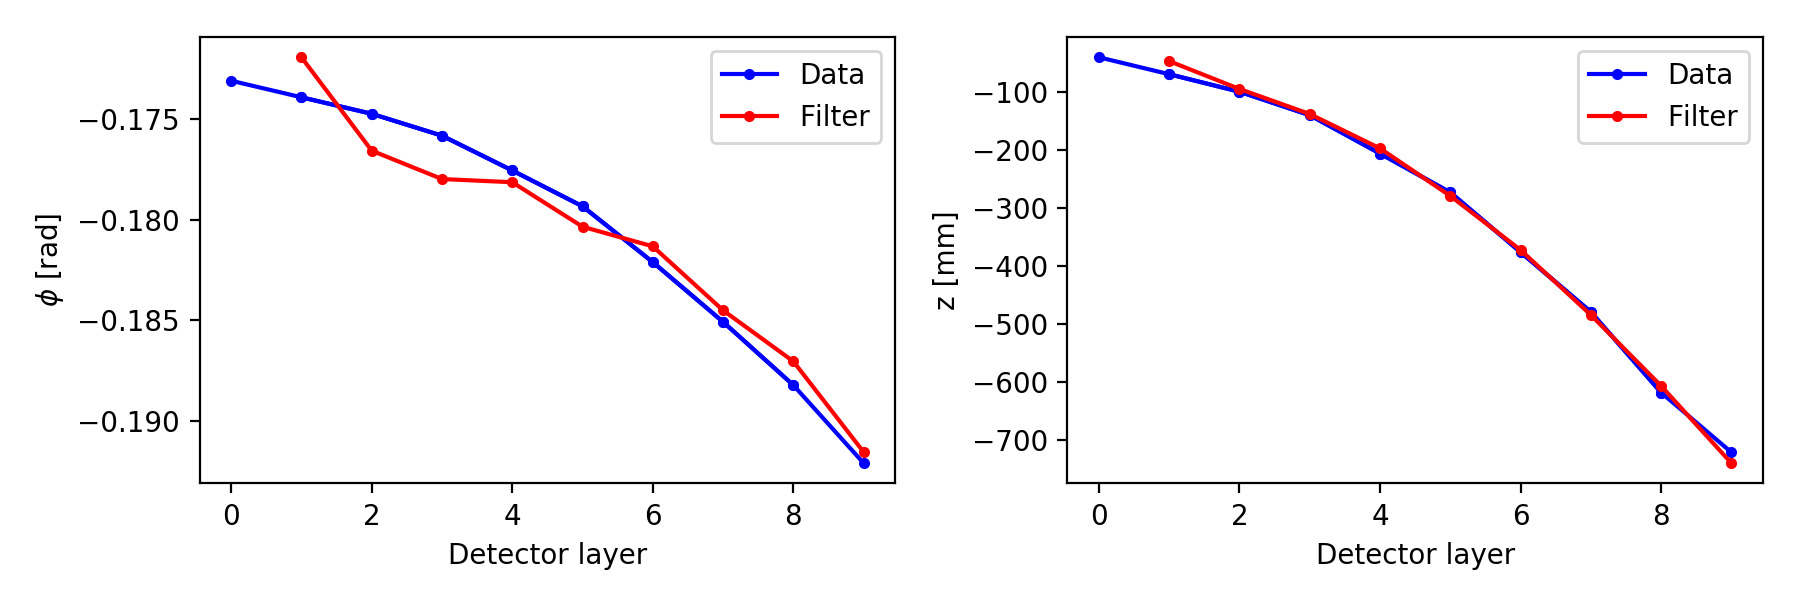

<IPython.core.display.Javascript object>


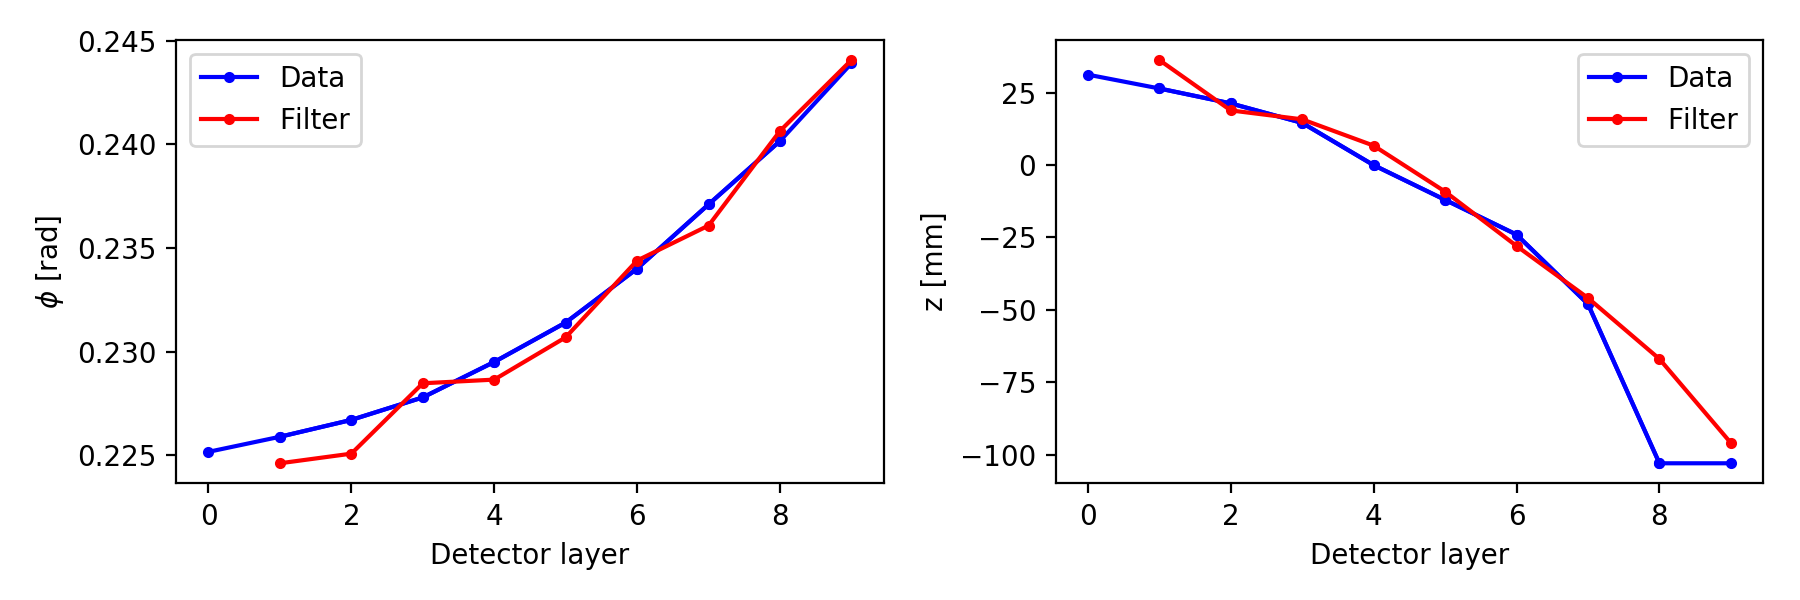

<IPython.core.display.Javascript object>


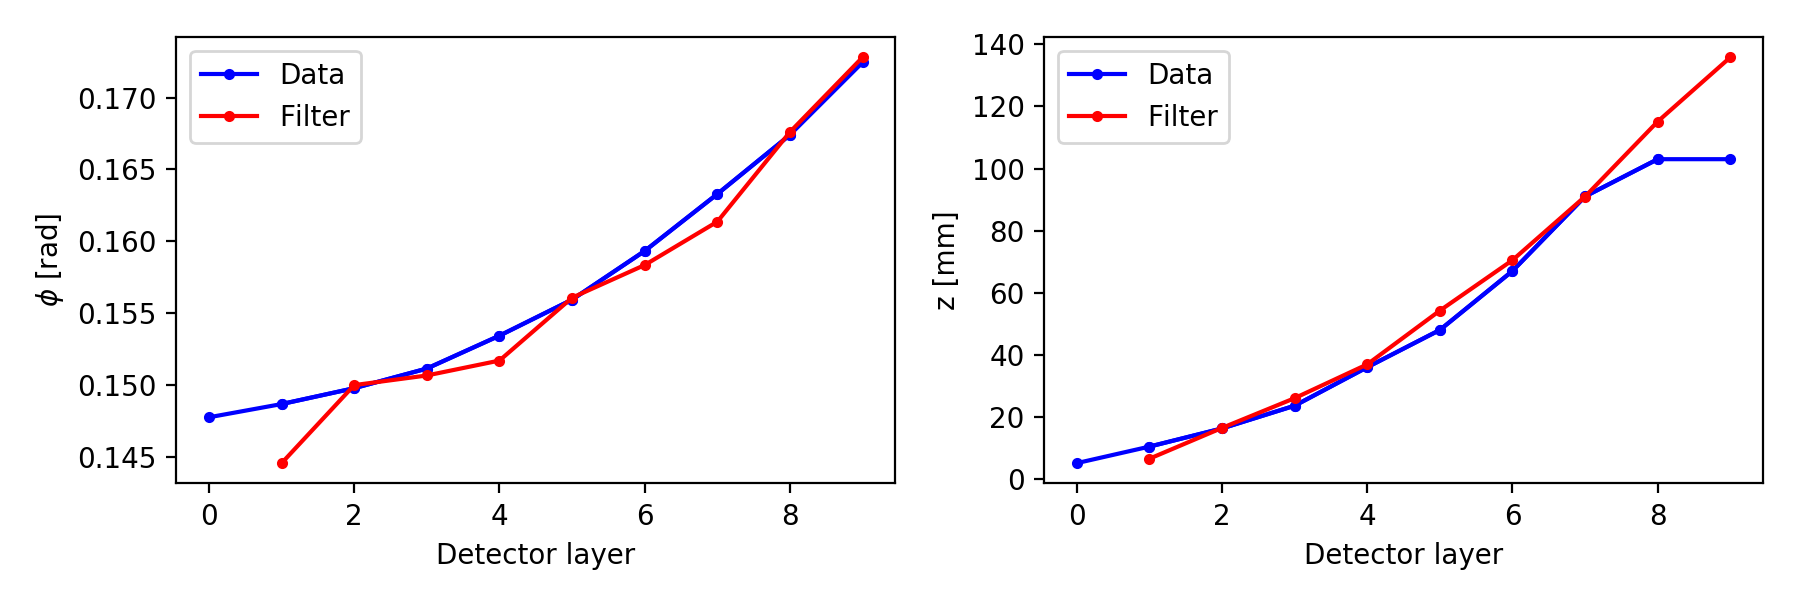

<IPython.core.display.Javascript object>


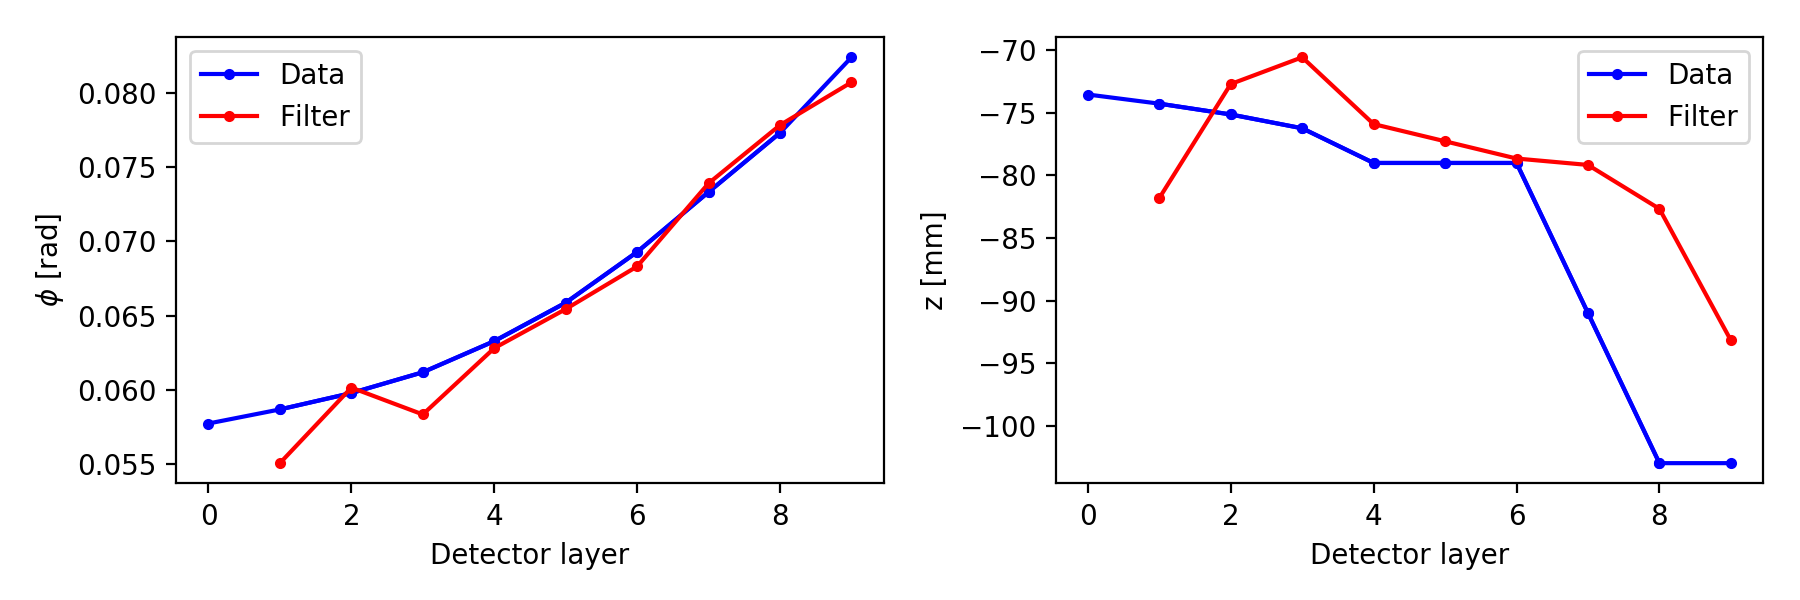

<IPython.core.display.Javascript object>


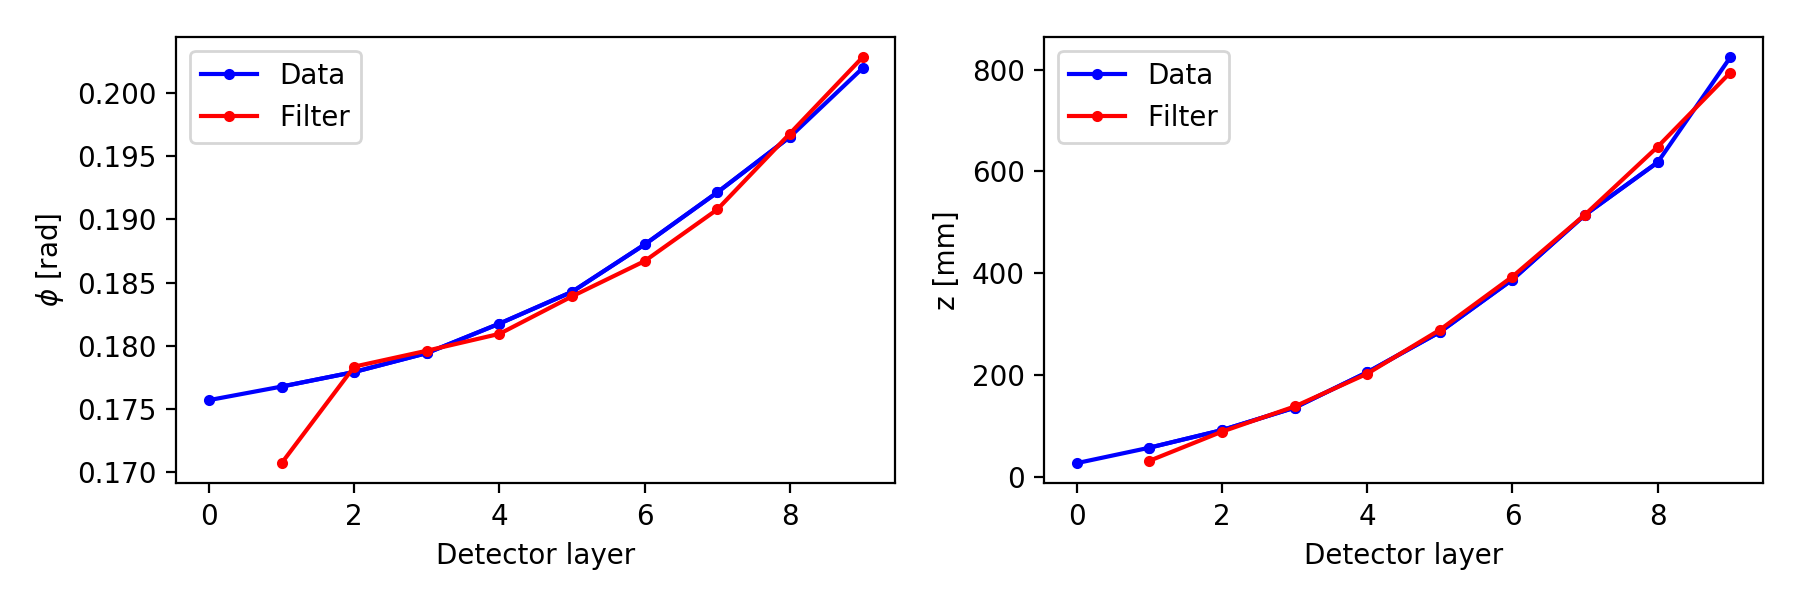

<IPython.core.display.Javascript object>


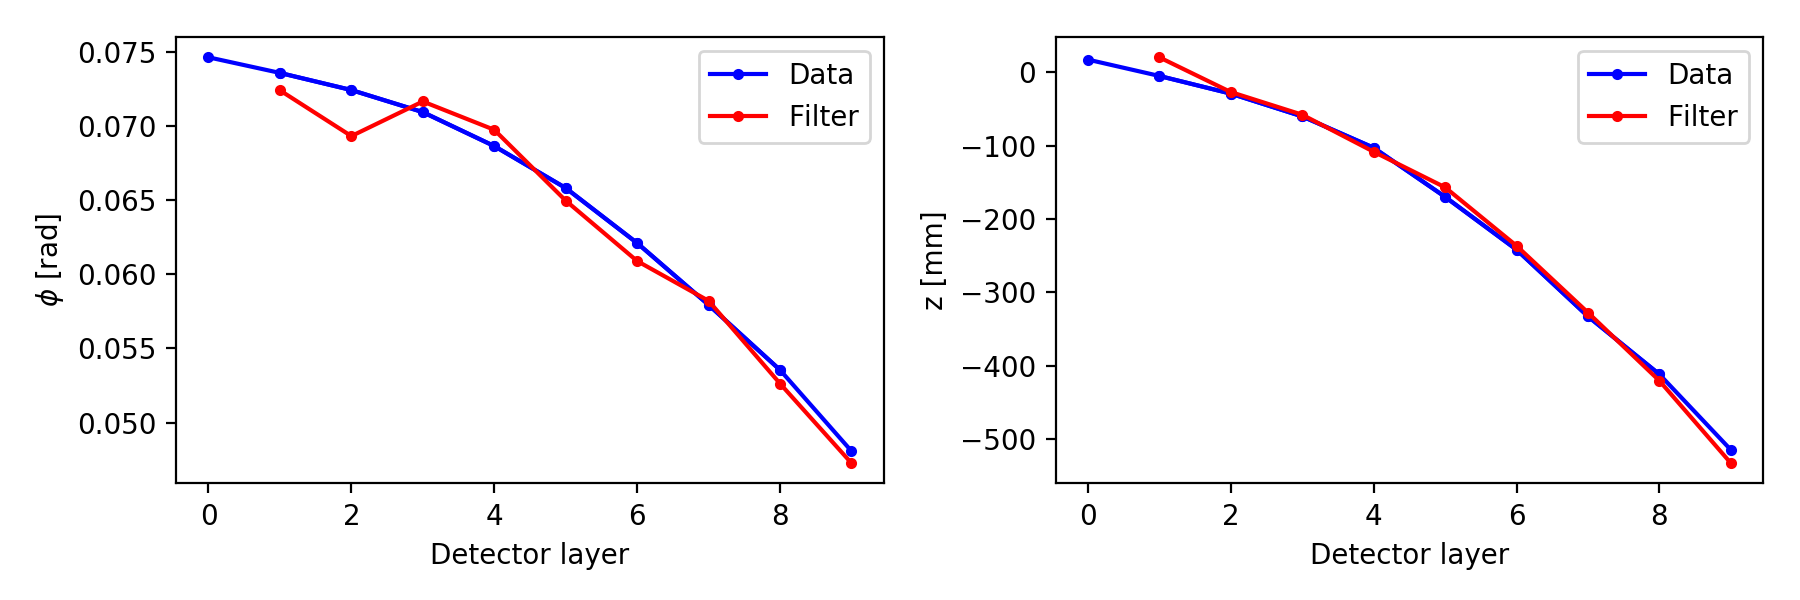

<IPython.core.display.Javascript object>


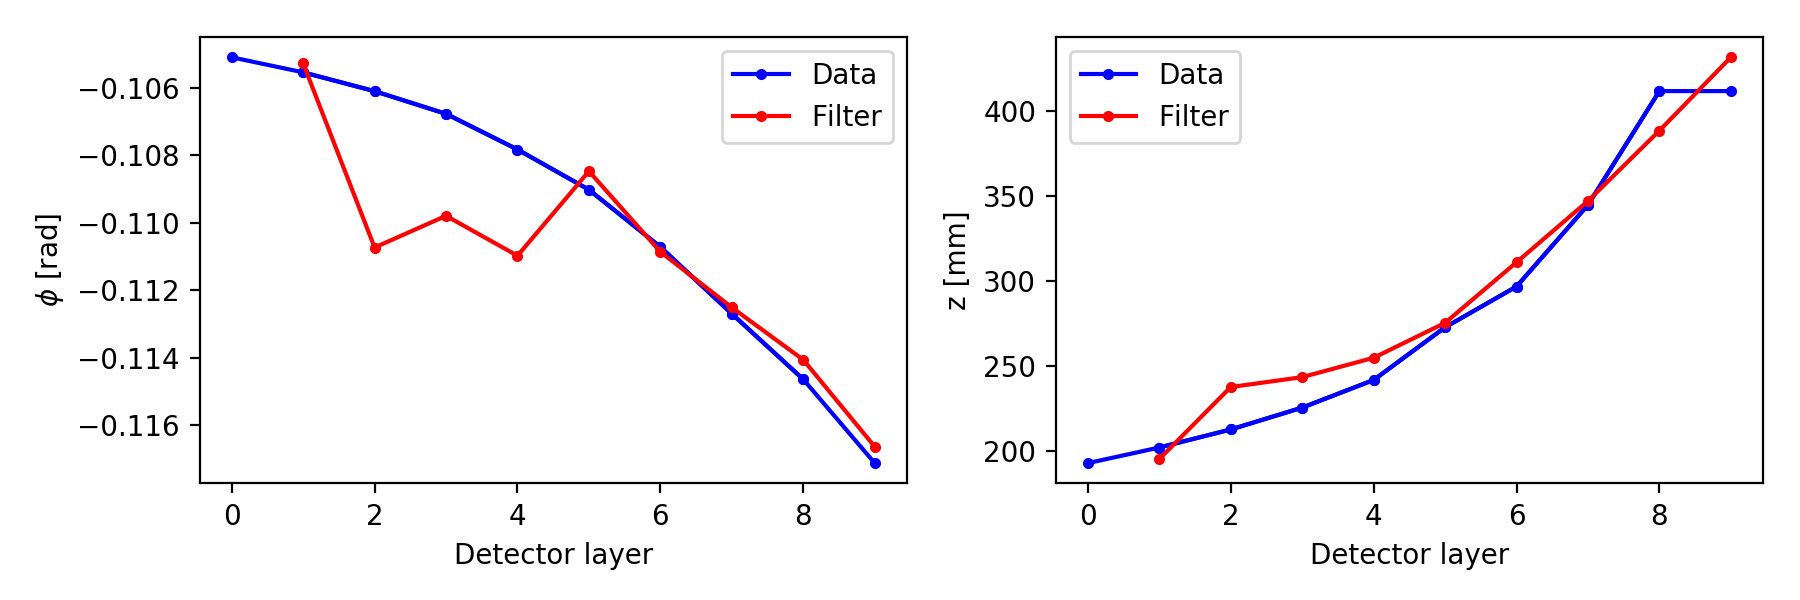

<IPython.core.display.Javascript object>


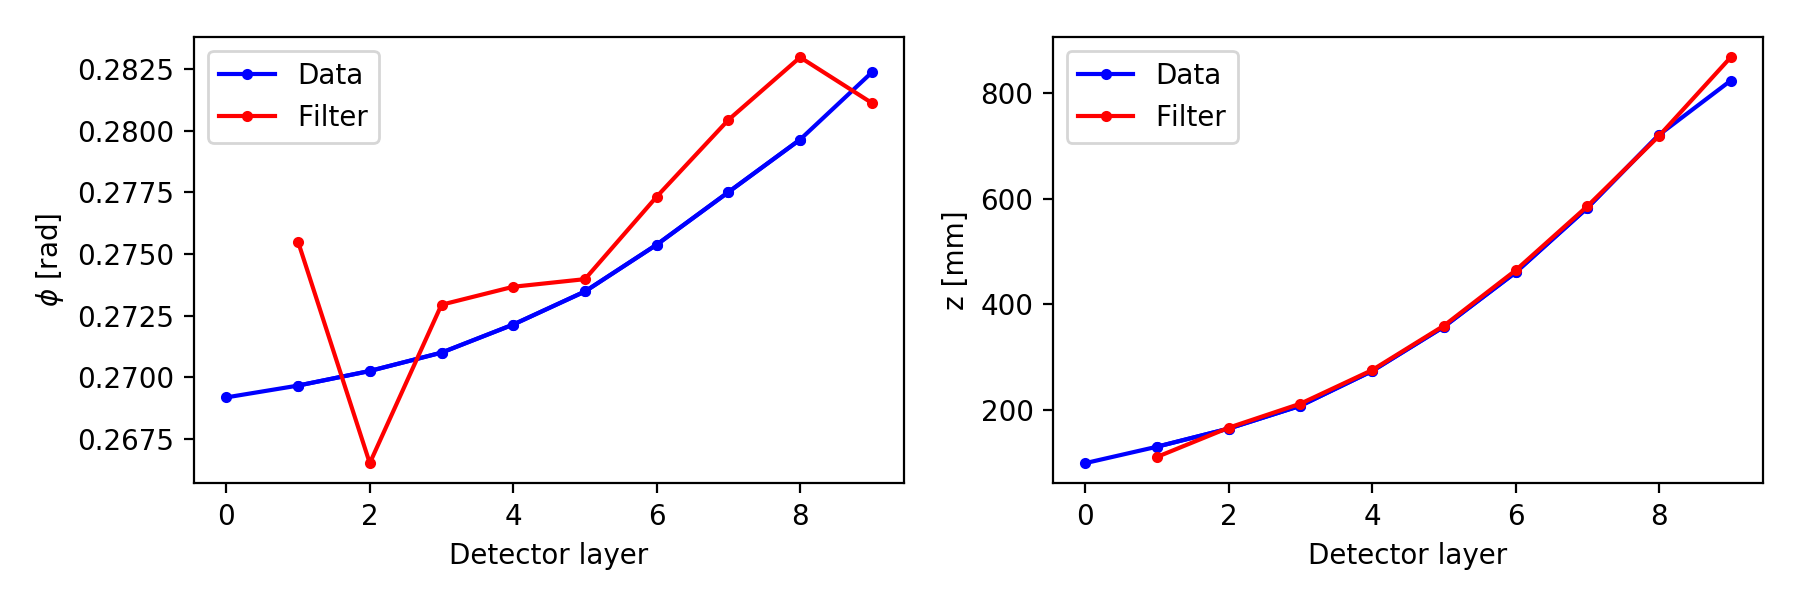

In [11]:
for i in range(10):
    layers = np.arange(10)
    inputs = torch_to_np(test_input[i]) * coord_scale
    outputs = torch_to_np(test_output[i]) * coord_scale[:2]
    targets = torch_to_np(test_target[i]) * coord_scale[:2]

    plt.figure(figsize=(9,3))

    plt.subplot(121)
    plt.plot(layers[:-1], inputs[:,0], 'b.-')
    plt.plot(layers[1:], targets[:,0], 'b.-', label='Data')
    plt.plot(layers[1:], outputs[:,0], 'r.-', label='Filter')
    plt.xlabel('Detector layer')
    plt.ylabel('$\phi$ [rad]')
    plt.legend(loc=0)

    plt.subplot(122)
    plt.plot(layers[:-1], inputs[:,1], 'b.-')
    plt.plot(layers[1:], targets[:,1], 'b.-', label='Data')
    plt.plot(layers[1:], outputs[:,1], 'r.-', label='Filter')
    plt.xlabel('Detector layer')
    plt.ylabel('z [mm]')
    plt.legend(loc=0)

    plt.tight_layout()

#### Observations

- Wrap-around at $\phi = \pi$ can screw up the filter (not currently shown).
- Filter is often smoother than data in the coarse outer layers.
- Few examples seem a bit unstable.